In [134]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [135]:
import pandas as pd
import numpy as np

In [136]:
training_df = pd.read_csv('train/training2.csv')

In [137]:
train_x = training_df.drop('spot', axis=1)
train_x.drop(columns=['Unnamed: 0'], inplace=True)

In [138]:
train_y = training_df['spot']

In [139]:
train_y = train_y.to_numpy()

In [140]:
train_x = train_x.to_numpy()

In [141]:
test_df = pd.read_csv('test/testing2.csv')

In [142]:
test_df.drop(columns=['Unnamed: 0'], inplace=True)

In [143]:
test_y = test_df['spot'].to_numpy()

In [144]:
import scipy.stats as ss

test_y = ss.zscore(test_y)
test_y

array([-2.22882834, -1.56115971, -1.27271453, ...,  0.03642771,
       -0.11199389, -0.09962543])

In [145]:
train_y = ss.zscore(train_y)

In [115]:
test_x = test_df.drop(columns=['spot']).to_numpy()

In [146]:
# create a discretized state vector for each 25 cent increment
# array positions (>=.75, .5-.75,.25-.5,0-.25, -.25-0, -.5--.25, -.75 - -.5, <= -.75)
def convert_to_vec(listy):
    ret_list = np.ndarray((len(listy), 8))
    for i, y in enumerate(listy):
        if y > 0:
            if y <= 0.50:
                ret_list[i] = np.array([0,0,0,1,0,0,0,0])
            elif y <= 1:
                ret_list[i] = np.array([0,0,1,0,0,0,0,0])
            elif y < 1.5:
                ret_list[i] = np.array([0,1,0,0,0,0,0,0])
            else:
                ret_list[i] = np.array([1,0,0,0,0,0,0,0])
        else:
            if y >= -0.5:
                ret_list[i] = np.array([0,0,0,0,1,0,0,0])
            elif y >= -1:
                ret_list[i] = np.array([0,0,0,0,0,1,0,0])
            elif y > -1.5:
                ret_list[i] = np.array([0,0,0,0,0,0,1,0])
            else:
                ret_list[i] = np.array([0,0,0,0,0,0,0,1])
    return ret_list

In [147]:
test_y = convert_to_vec(test_y)
train_y = convert_to_vec(train_y)

We now have cleaned NP arrays for our training and testing inputs and outputs, so we begin constructing a Keras model.

In [148]:
model = keras.Sequential()
model.add(keras.Input(shape=(59,), name='Timeseries'))
model.add(layers.Dense(30, name="hidden1", activation='relu'))
model.add(layers.Dense(15, name='hidden2', activation='relu'))
model.add(layers.Dense(8, name="output", activation='softmax'))

model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 30)                1800      
                                                                 
 hidden2 (Dense)             (None, 15)                465       
                                                                 
 output (Dense)              (None, 8)                 128       
                                                                 
Total params: 2,393
Trainable params: 2,393
Non-trainable params: 0
_________________________________________________________________


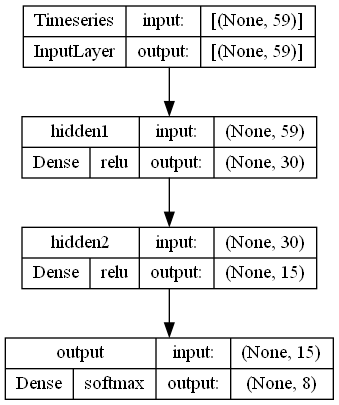

In [149]:
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [150]:
np.shape(train_x)

(2277, 59)

In [151]:
# reserve ~10% for inter-epoch validation
val_x = train_x[-200:]
val_y = train_y[-200:]
train_x = train_x[:-200]
train_y = train_y[:-200]


In [152]:
model.compile(
    optimizer=keras.optimizers.SGD(), # stoch grad descent
    loss=keras.losses.MeanSquaredError(), # MSE loss function to minimize
    metrics=[keras.metrics.Accuracy()],
)

In [153]:
session = model.fit(
    train_x,
    train_y,
    batch_size=50,
    epochs=100, 
    validation_data=(val_x, val_y),
)

Epoch 1/100
42/42 [==============================] - 1s 5ms/step - loss: 0.1096 - accuracy: 0.0000e+00 - val_loss: 0.1093 - val_accuracy: 0.0000e+00
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - val_loss: 0.1093 - val_accuracy: 0.0000e+00
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - val_loss: 0.1093 - val_accuracy: 0.0000e+00
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - val_loss: 0.1093 - val_accuracy: 0.0000e+00
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - val_loss: 0.1092 - val_accuracy: 0.0000e+00
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - val_loss: 0.1092 - val_accuracy: 0.0000e+00
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - v

In [155]:
results = model.evaluate(test_x, test_y, batch_size=100)
print("test loss, test acc:", results)

16/16 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 0.0000e+00
test loss, test acc: [0.10850250720977783, 0.0]


In [156]:
predictions = model.predict(test_x)
predictions

47/47 [==============================] - 0s 2ms/step


array([[0.10918082, 0.10766008, 0.12684911, ..., 0.13656473, 0.12531227,
        0.11564217],
       [0.10344737, 0.10675892, 0.13009146, ..., 0.14070375, 0.11677694,
        0.10968083],
       [0.0960683 , 0.10888436, 0.13669746, ..., 0.14202352, 0.11831487,
        0.1264271 ],
       ...,
       [0.11444746, 0.11517481, 0.12343445, ..., 0.12678312, 0.11092293,
        0.10525072],
       [0.11333883, 0.11276842, 0.12364338, ..., 0.1293679 , 0.1141069 ,
        0.10684897],
       [0.11282009, 0.11560916, 0.12433066, ..., 0.12624773, 0.10990389,
        0.10779972]], dtype=float32)

In [157]:
direction_success = 0
for i, pred in enumerate(predictions):
    pred_index = np.argmax(pred)
    test_index = np.argmax(test_y[i])
    if pred_index <= 3  and test_index <= 3:
        direction_success += 1
    elif pred_index > 3 and test_index > 3:
        direction_success += 1

In [158]:
direction_success / len(test_y)

0.4630246502331779

In [159]:
tick_success = 0
histogram = [0,0,0,0,0,0,0,0]
for i, pred in enumerate(predictions):
    pred_index = np.argmax(pred)
    test_index = np.argmax(test_y[i])
    histogram[test_index] = histogram[test_index] + 1
    if pred_index == test_index:
        tick_success += 1

In [160]:
tick_success / len(test_y)

0.15656229180546302

In [161]:
histogram

[159, 124, 172, 248, 258, 286, 197, 57]

In [104]:
predictions

array([[0.46318364, 0.04864341, 0.09508181, ..., 0.05794706, 0.0937846 ,
        0.08781937],
       [0.49740854, 0.04120875, 0.09176078, ..., 0.04964045, 0.09547868,
        0.08162538],
       [0.44819853, 0.04854925, 0.09113719, ..., 0.06518588, 0.09553953,
        0.08707712],
       ...,
       [0.4517586 , 0.05240608, 0.09598842, ..., 0.06360875, 0.08767015,
        0.08830915],
       [0.44118604, 0.05429742, 0.09633449, ..., 0.0649247 , 0.08803296,
        0.09090717],
       [0.45957834, 0.04998467, 0.09388395, ..., 0.06248721, 0.08869751,
        0.08669905]], dtype=float32)